In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
import matplotlib.pyplot as plt
import itertools
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,mean_squared_log_error
from torch import nn
%matplotlib inline
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [2]:
# data processing For ARIMA
raw_data = pd.read_csv('data/ABC_data.csv')
print(raw_data)
data_name = 'ABC_prue_ARIMA'
section_name = 'ABC'
train_len = 1000
# training and test set for ARIMA
ARIMA_Train = raw_data.loc[:,['close']][0:train_len]
ARIMA_Test =  raw_data.loc[:,['close']][train_len:]
ARIMA_Test_Input = raw_data.loc[:,['date']][train_len:]

            date   open    high      low  close   volume Name
0     2013-02-08  46.52  46.895  46.4600  46.89  1232802  ABC
1     2013-02-11  46.85  47.000  46.5000  46.76  1115888  ABC
2     2013-02-12  46.70  47.050  46.6000  46.96  1318773  ABC
3     2013-02-13  46.74  46.900  46.6000  46.64  2645247  ABC
4     2013-02-14  46.67  46.990  46.6000  46.77  1941879  ABC
...          ...    ...     ...      ...    ...      ...  ...
1254  2018-02-01  97.74  99.810  95.7300  99.29  2786798  ABC
1255  2018-02-02  99.09  99.090  95.9100  96.02  1660267  ABC
1256  2018-02-05  95.62  96.520  91.6900  91.90  2278534  ABC
1257  2018-02-06  92.58  93.370  86.9403  91.54  4574997  ABC
1258  2018-02-07  91.60  95.340  91.1000  94.22  2509484  ABC

[1259 rows x 7 columns]


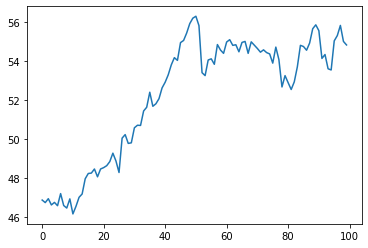

In [3]:
ARIMA_mean_log = np.log(raw_data.loc[:,['close']])
plt.plot(ARIMA_Train.iloc[:100])

In [4]:
# sp500 (7,1,1)  ABC (7,1,2)  AAL(6,1,0)
order = (7,1,1)

In [5]:
# fit
model = ARIMA(ARIMA_Train, order)
fit = model.fit()

/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/miniconda3/envs/nlu_cw2/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

In [6]:
# predict 
preds = fit.predict(1,len(raw_data),typ='levels')
preds_pd = preds.to_frame()
preds_pd.index -= 1
print(preds_pd)

              0
0     46.925031
1     46.798563
2     46.984542
3     46.689946
4     46.791574
...         ...
1254  90.929699
1255  90.964730
1256  90.999761
1257  91.034793
1258  91.069824

[1259 rows x 1 columns]


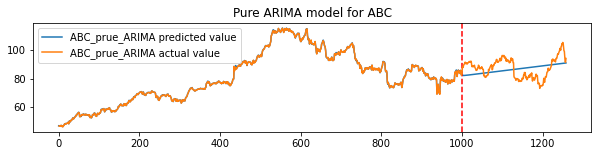

In [7]:
# draw predict figure
plt.figure(figsize=(10, 2))
plt.title("Pure ARIMA model for {}".format(section_name))
plt.plot(preds_pd,label="{} predicted value".format(data_name))
# plt.plot(ARIMA_Train.iloc[6600:6754],label="request delay")
plt.axvline(x=train_len, c='r', linestyle='--')
plt.plot(raw_data.iloc[1:]["close"],label="{} actual value".format(data_name))
plt.legend()
plt.show()

In [8]:
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ARIMA_Result['raw'] = raw_data['close']
ARIMA_Result['predicted'] = preds_pd
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']
# ARIMA_Result.to_csv('residual_result/{}_residual.csv'.format(data_name))
ARIMA_Result

,raw,predicted,residuals
0,46.89,46.925031,-0.035031
1,46.76,46.798563,-0.038563
2,46.96,46.984542,-0.024542
3,46.64,46.689946,-0.049946
4,46.77,46.791574,-0.021574
...,...,...,...
1254,99.29,90.929699,8.360301
1255,96.02,90.964730,5.055270
1256,91.90,90.999761,0.900239
1257,91.54,91.034793,0.505207


In [9]:
mse = mean_squared_error(ARIMA_Result['raw'][train_len:], ARIMA_Result['predicted'][train_len:])   # 5500  
mae = mean_absolute_error(ARIMA_Result['raw'][train_len:], ARIMA_Result['predicted'][train_len:])
mape = mean_absolute_percentage_error(ARIMA_Result['raw'][train_len:], ARIMA_Result['predicted'][train_len:])*100
rmsle = np.sqrt(mean_squared_log_error(ARIMA_Result['raw'][train_len:], ARIMA_Result['predicted'][train_len:]))
rmse = np.sqrt(mse)

print(f'X_test MSE: {mse}')
print(f'X_test MAE: {mae}')
print('X_test MAPE:{}%'.format(mape))
print(f'X_test RMSLE: {rmsle}')
print(f'X_test RMSE: {rmse}')

X_test MSE: 53.502210263529705
X_test MAE: 6.610008197490209
X_test MAPE:7.618422787783974%
X_test RMSLE: 0.08330458489271478
X_test RMSE: 7.314520508107808
